# CENTRALITY IS ALL YOU NEED
## LFN Project

### Description of the project
- **Aim**: try to detect the most influential political figures and their political party.

## Load libraries

In [1]:
#!pip install networkit
#!pip install pyvis
import networkx as nx
import networkit as nk
import csv
import time
from tqdm import tqdm
import pandas as pd
import numpy as np
from pyvis.network import Network
from tqdm import tqdm
import matplotlib.pyplot as plt

## Loading of the graph and calculation of some metrics

In [2]:
edges = pd.read_csv("data/fb-pages-politician.edges", sep = ",", header=None)
nodes = pd.read_csv("data/fb-pages-politician.nodes", sep = ",")

In [3]:
nodes

,id,name,new_id
0,127397457601670,陳根德,1661
1,169014523134260,林淑芬,52
2,295363753921281,Chris White,3477
3,613631835423903,Stewart Hosie MP,3193
4,284882801581896,Frank Schäffler,4425
...,...,...,...
5903,342943772496246,Kevin Byrne,3778
5904,193944157325672,Timur Husein,439
5905,142026376065,Jeremy Lefroy,159
5906,294019144024664,Ileana Argentin,107


In [4]:
#needs a dictionary in order to relabel the nodes
labelsDict = pd.Series(nodes.name.values,index=nodes.new_id).to_dict()

In [5]:
G = nx.Graph()
G = nx.from_pandas_edgelist(edges,0, 1)
G = nx.relabel_nodes(G, labelsDict)

In [6]:
G.is_directed()

False

In [7]:
nkG = nk.nxadapter.nx2nk(G)

In [8]:
print("Is G connected? ",nx.is_connected(G))
print("Number of connected components: ", nx.number_connected_components(G))

Is G connected?  True
Number of connected components:  1


In [9]:
#connected components with networkit
cc = nk.components.ConnectedComponents(nkG)
cc.run()
print("number of components ", cc.numberOfComponents())
print("map of component size: ", cc.getComponentSizes())

number of components  1
map of component size:  {0: 5906}


In [10]:
#diameter (estimate)
#This algorithm gives an estimation of the diameter of a given graph. The algorithm is based on the ExactSumSweep algorithm presented in Michele Borassi, Pierluigi Crescenzi, Michel Habib, Walter A. Kosters, Andrea Marino, Frank W. Takes: http://www.sciencedirect.com/science/article/pii/S0304397515001644.
diam = nk.distance.Diameter(nkG,algo=1)
diam.run()
diam.getDiameter() 
#The return value of getDiameter is a pair of integers: the lower bound and upper bound of the diameter. 
#In the case, that we computed the exact diameter, the diameter is the first value of the pair.

(14, 0)

In [11]:
#diameter (effective)
#The effective diameter is defined as the number of edges on average to reach a given ratio of all other nodes.
#The EffectiveDiameter(G, ratio=0.9) constructor expects an undirected graph and the ratio of nodes that should be connected. The ratio must be between in the interval (0,1].
ed = nk.distance.EffectiveDiameter(nkG)
ed.run()
ed.getEffectiveDiameter()

5.816796478157806

In [12]:
#effective diameter approximation
eda = nk.distance.EffectiveDiameterApproximation(nkG)
eda.run()
eda.getEffectiveDiameter()

5.773958686081951

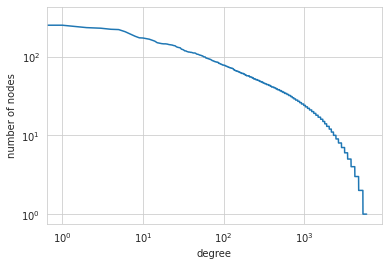

In [13]:
#degree distribution in our original graph
dd = sorted(nk.centrality.DegreeCentrality(nkG).run().scores(), reverse=True)
plt.xscale("log")
plt.xlabel("degree")
plt.yscale("log")
plt.ylabel("number of nodes")
plt.plot(dd)
plt.show()

In [14]:
#some info in our original graph if we are interested
communities = nk.community.detectCommunities(nkG)
nk.community.Modularity().getQuality(communities, nkG)

PLM(balanced,pc,turbo) detected communities in 0.02368640899658203 [s]
solution properties:
-------------------  ----------
# communities         31
min community size     8
max community size   591
avg. community size  190.516
modularity             0.868218
-------------------  ----------


0.8682176124665733

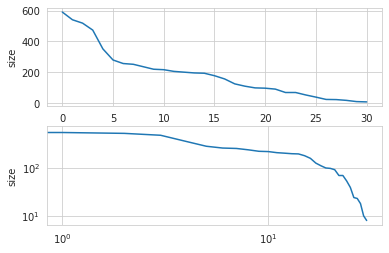

In [15]:
sizes = communities.subsetSizes()
sizes.sort(reverse=True)
ax1 = plt.subplot(2,1,1)
ax1.set_ylabel("size")
ax1.plot(sizes)

ax2 = plt.subplot(2,1,2)
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_ylabel("size")
ax2.plot(sizes)
plt.show()

## Closeness and Betweenness centrality

In [16]:
def centrality(G,alg, lib):
    if alg == "closeness" and lib == "nx":
        start_time = time.time()
        colsenessCentrality_nx = nx.closeness_centrality(G)
        print("--- %s seconds ---" % (time.time() - start_time))
        return colsenessCentrality_nx
    if alg == "betweenness" and lib == "nx":
        start_time = time.time()
        betweennessCentrality_nx = nx.betweenness_centrality(G)
        print("--- %s seconds ---" % (time.time() - start_time))
        return betweennessCentrality_nx
    if alg == "closeness" and lib == "nk":
        start_time = time.time()
        nkColsenessCentrality = nk.centrality.Closeness(G,True,False).run()
        print("--- %s seconds ---" % (time.time() - start_time))
        return nkColsenessCentrality.ranking()
    if alg == "betweenness" and lib == "nk":
        start_time = time.time()
        nkBetweennessCentrality = nk.centrality.Betweenness(G,True,False).run()
        print("--- %s seconds ---" % (time.time() - start_time))
        return nkBetweennessCentrality.ranking()
    if alg == "approxclose" and lib == "nk":
        start_time = time.time()
        nkApproxColsenessCentrality = nk.centrality.ApproxCloseness(G,True,False).run()
        print("--- %s seconds ---" % (time.time() - start_time))
        return nkApproxColsenessCentrality.ranking()
    if alg == "approxbet" and lib == "nk":
        start_time = time.time()
        nkApproxBetweennessCentrality = nk.centrality.ApproxBetweenness(G).run()
        print("--- %s seconds ---" % (time.time() - start_time))
        return nkApproxBetweennessCentrality.ranking()

In [22]:
#centrality(G,"closeness","nx")

--- 47.06798434257507 seconds ---


{'Mark Bailey MP - Labor for Miller': 0.2479217398606096,
 'Jo-Ann Miller MP': 0.28501785886668596,
 'Senator Claire Moore': 0.24067658447116363,
 'Shane King MP-  Labor for Kurwongbah': 0.23458604798982996,
 'Di Farmer MP': 0.23739647825038193,
 'Leanne Linard MP': 0.2340282181357007,
 'Aaron Harper MP': 0.23984565393988627,
 'Sénateur Pierre-Hugues Boisvenu': 0.25438331969155215,
 'Jackie Trad': 0.2445033331953128,
 'Jim Madden - Labor for Ipswich West': 0.23985539623867744,
 '邱志偉': 0.23125122381045624,
 'Grace Grace MP': 0.23892373052801943,
 'Senator Chris Ketter': 0.24451345755693582,
 'Bill Shorten MP': 0.2734935852901672,
 'Craig Crawford - Labor For Barron River': 0.24564249760805357,
 'Stirling Hinchliffe MP': 0.24423029200099264,
 'Mark Ryan MP': 0.2536512027491409,
 'Dr Anthony Lynham': 0.2390785052026398,
 'Joe Kelly MP': 0.24162199762674413,
 'Linus Power': 0.24377657598150518,
 'Luke Howarth': 0.2566721724767452,
 'Andrew Leigh MP': 0.2450410822474894,
 'Don Brown MP': 0.

In [17]:
centrality(nkG,"closeness","nk")

--- 0.4936397075653076 seconds ---


[(703, 0.3588574901245822),
 (853, 0.3235084643620227),
 (941, 0.32047107348312165),
 (855, 0.3174219211955061),
 (228, 0.3124669277172188),
 (157, 0.31085491682459465),
 (50, 0.3096973829128861),
 (219, 0.3075360658299047),
 (810, 0.30554693159474283),
 (233, 0.3051521885173893),
 (177, 0.30491583187028815),
 (857, 0.30389583654984303),
 (147, 0.30261876697586226),
 (209, 0.3008763884642821),
 (424, 0.29979184647408236),
 (948, 0.2995637175324676),
 (1392, 0.2960641764853347),
 (2910, 0.29591581057379107),
 (2527, 0.2958120428814748),
 (2123, 0.29579722486600213),
 (34, 0.29533860158047415),
 (255, 0.29471950489119586),
 (214, 0.2946459757497131),
 (57, 0.2932849905632264),
 (2495, 0.2932412971147639),
 (799, 0.29271798939176125),
 (692, 0.2926889714993804),
 (308, 0.29238463061992476),
 (213, 0.28997250049106266),
 (943, 0.28957434287956063),
 (1887, 0.28936149360513547),
 (230, 0.2890357317670093),
 (1576, 0.2890215848465567),
 (138, 0.28893673239712286),
 (247, 0.28878129890453835)

In [24]:
#centrality(G,"betweenness","nx")

--- 191.05804204940796 seconds ---


{'Mark Bailey MP - Labor for Miller': 0.00015704690880821877,
 'Jo-Ann Miller MP': 0.003622567572049236,
 'Senator Claire Moore': 3.0391491689467818e-05,
 'Shane King MP-  Labor for Kurwongbah': 7.558013769192619e-06,
 'Di Farmer MP': 1.3217045674452099e-05,
 'Leanne Linard MP': 2.8304325209334307e-05,
 'Aaron Harper MP': 3.6119407945364613e-05,
 'Sénateur Pierre-Hugues Boisvenu': 0.0034715850285264626,
 'Jackie Trad': 0.0002315851911273831,
 'Jim Madden - Labor for Ipswich West': 1.3753381654531965e-05,
 '邱志偉': 0.0009267561274619335,
 'Grace Grace MP': 2.0367504293817236e-05,
 'Senator Chris Ketter': 0.00029847026197884975,
 'Bill Shorten MP': 0.009342744840905156,
 'Craig Crawford - Labor For Barron River': 0.00011441971646975493,
 'Stirling Hinchliffe MP': 0.00013155311713819763,
 'Mark Ryan MP': 0.0017369151141793386,
 'Dr Anthony Lynham': 2.8117955370540076e-05,
 'Joe Kelly MP': 4.7822553272661366e-05,
 'Linus Power': 0.0001292649442780126,
 'Luke Howarth': 0.0002881606999433047,


In [18]:
centrality(nkG,"betweenness","nk")

--- 4.626946210861206 seconds ---


[(703, 0.536616440273453),
 (177, 0.11104196490780699),
 (157, 0.10829224089393592),
 (810, 0.09654886256228755),
 (255, 0.09017589220675054),
 (140, 0.07455223950912733),
 (50, 0.07073600343133898),
 (951, 0.06816026594327243),
 (138, 0.06358624632468853),
 (638, 0.05798552776765502),
 (308, 0.05758472422797191),
 (853, 0.05559133272319923),
 (209, 0.046998406061421916),
 (2495, 0.04551044945392929),
 (202, 0.0441934905774366),
 (767, 0.04380878402193166),
 (228, 0.04346008515930888),
 (2910, 0.0400754744832307),
 (855, 0.04004459839665027),
 (1027, 0.039309839749330354),
 (941, 0.038083170178616815),
 (147, 0.0378214929569395),
 (1229, 0.03777859538763543),
 (1265, 0.03668379124514484),
 (1392, 0.03665625937969772),
 (243, 0.03444987411398087),
 (34, 0.03324997301123423),
 (857, 0.03253121435876723),
 (1231, 0.031400149662922906),
 (2123, 0.03046370619024702),
 (3723, 0.029623480315722064),
 (708, 0.029332385231254837),
 (219, 0.0293289444039085),
 (1397, 0.028578412735030905),
 (233

In [19]:
centrality(nkG,"approxclose","nk")

--- 0.008576631546020508 seconds ---


[(314, 0.00016934801016088062),
 (2256, 0.00016934801016088062),
 (2601, 0.00016934801016088062),
 (148, 8.467400508044031e-05),
 (310, 8.467400508044031e-05),
 (313, 8.467400508044031e-05),
 (746, 8.467400508044031e-05),
 (751, 8.467400508044031e-05),
 (754, 8.467400508044031e-05),
 (810, 8.467400508044031e-05),
 (824, 8.467400508044031e-05),
 (855, 8.467400508044031e-05),
 (868, 8.467400508044031e-05),
 (941, 8.467400508044031e-05),
 (1458, 8.467400508044031e-05),
 (1468, 8.467400508044031e-05),
 (1470, 8.467400508044031e-05),
 (1472, 8.467400508044031e-05),
 (1473, 8.467400508044031e-05),
 (1476, 8.467400508044031e-05),
 (1477, 8.467400508044031e-05),
 (1721, 8.467400508044031e-05),
 (1763, 8.467400508044031e-05),
 (1870, 8.467400508044031e-05),
 (2212, 8.467400508044031e-05),
 (2227, 8.467400508044031e-05),
 (2245, 8.467400508044031e-05),
 (2246, 8.467400508044031e-05),
 (2247, 8.467400508044031e-05),
 (2248, 8.467400508044031e-05),
 (2249, 8.467400508044031e-05),
 (2251, 8.4674005

In [20]:
centrality(nkG,"approxbet","nk")

--- 23.905261039733887 seconds ---


[(703, 0.2656861939583382),
 (157, 0.05488456166296868),
 (177, 0.054446361569851165),
 (810, 0.04896886040588225),
 (255, 0.04538109714348261),
 (140, 0.03697313285679032),
 (50, 0.03580916385944692),
 (951, 0.033399063347300605),
 (138, 0.03200230055048853),
 (638, 0.029564812532522355),
 (308, 0.02918138745104453),
 (853, 0.02738750581984471),
 (228, 0.023046586147399344),
 (2495, 0.022895954865390197),
 (209, 0.02236189850190323),
 (202, 0.02189631090296587),
 (767, 0.02134856078656898),
 (855, 0.02034891682414465),
 (1027, 0.020129816777585893),
 (2910, 0.019239722838440946),
 (147, 0.018911072768602807),
 (1229, 0.018842604004053198),
 (941, 0.018746747733683743),
 (1265, 0.018555035192944828),
 (1392, 0.018294853887656306),
 (243, 0.017391066195601435),
 (34, 0.0173089036781419),
 (857, 0.015775203352230604),
 (2123, 0.0156519595760413),
 (1231, 0.01546024703530239),
 (708, 0.0150357406950948),
 (219, 0.014830334401445967),
 (1397, 0.014159340508859773),
 (3723, 0.01389915920357

In [ ]:
#visualize a subgraph
#H = G.subgraph(list(G.nodes)[:100])
#nt = Network('900px','1820px')
#nt.from_nx(H)
#nt.show('nx.html')

## Global and local clustering coefficient

In [21]:
#Returns approximate average average local clustering coefficient (networkit)
ACC_nkG = nk.globals.clustering(nkG)
ACC_nkG

0.4335533744462781

In [22]:
#Local Clustering Coefficient does not accept graphs with self loops.
#We remove them and compute the scores 
nkG.removeSelfLoops()
LCC_nkG = nk.centrality.LocalClusteringCoefficient(nkG).run()

In [23]:
len(LCC_nkG.scores()),LCC_nkG.scores()

(5906,
 [0.5739957716701902,
  0.4423558897243108,
  0.5113636363636364,
  0.819047619047619,
  0.7719298245614035,
  0.7333333333333333,
  0.7142857142857143,
  0.3745632424877708,
  0.5032377428307123,
  0.7631578947368421,
  0.3790849673202614,
  0.7350427350427351,
  0.3911421911421911,
  0.2367816091954023,
  0.5231372549019608,
  0.6102418207681366,
  0.5505050505050505,
  0.6628787878787878,
  0.7792207792207793,
  0.6413793103448275,
  0.4117647058823529,
  0.4788732394366197,
  0.7660098522167488,
  0.578494623655914,
  0.25117845117845117,
  0.4767676767676768,
  0.673202614379085,
  0.6773109243697479,
  0.4250380517503805,
  0.3841313269493844,
  0.4231578947368421,
  0.5245143385753932,
  0.8260869565217391,
  0.3886832363828662,
  0.19473180076628352,
  0.6193181818181818,
  0.37462537462537465,
  0.5285024154589372,
  0.8382352941176471,
  0.4919636617749825,
  0.3075091575091575,
  0.20425129900803024,
  0.783625730994152,
  0.4439746300211416,
  0.6623655913978495,
  0

In [24]:
#Returns average clustering coefficient with networkx
ACC_nxG = nx.average_clustering(G)
ACC_nxG

0.38526532797801083

In [25]:
#Networkx does not return an error for the self loops.
#However we obtain a dictionary of the same length, 
#so it removes implicity the self loops
LCC_nxG = nx.clustering(G)
len(LCC_nxG), LCC_nxG

(5906,
 {'Mark Bailey MP - Labor for Miller': 0.5739957716701902,
  'Jo-Ann Miller MP': 0.4423558897243108,
  'Senator Claire Moore': 0.5113636363636364,
  'Shane King MP-  Labor for Kurwongbah': 0.819047619047619,
  'Di Farmer MP': 0.7719298245614035,
  'Leanne Linard MP': 0.7333333333333333,
  'Aaron Harper MP': 0.7142857142857143,
  'Sénateur Pierre-Hugues Boisvenu': 0.3745632424877708,
  'Jackie Trad': 0.5032377428307123,
  'Jim Madden - Labor for Ipswich West': 0.7631578947368421,
  '邱志偉': 0.3790849673202614,
  'Grace Grace MP': 0.7350427350427351,
  'Senator Chris Ketter': 0.3911421911421911,
  'Bill Shorten MP': 0.2367816091954023,
  'Craig Crawford - Labor For Barron River': 0.5231372549019608,
  'Stirling Hinchliffe MP': 0.6102418207681366,
  'Mark Ryan MP': 0.5505050505050505,
  'Dr Anthony Lynham': 0.6628787878787878,
  'Joe Kelly MP': 0.7792207792207793,
  'Linus Power': 0.6413793103448275,
  'Luke Howarth': 0.4117647058823529,
  'Andrew Leigh MP': 0.4788732394366197,
  'Do

## Random Graphs

In [26]:
#Erdös-Renyi model
ERD = nk.generators.ErdosRenyiGenerator(G.number_of_nodes(), 0.2).generate()
print(ERD.numberOfNodes(), ERD.numberOfEdges())
#nk.community.detectCommunities(ERD)

5906 3489450


In [27]:
#Simple variant of Erdös-Renyi model
#The node set is partitioned into a given number of subsets. Nodes within the same subset have a higher edge probability.
CRG = nk.generators.ClusteredRandomGraphGenerator(G.number_of_nodes(), 4, 0.2, 0.002).generate()
print(CRG.numberOfNodes(), CRG.numberOfEdges())
#nk.community.detectCommunities(CRG)

5906 896610


In [28]:
#Chung-Lu model
degreeSequence = [CRG.degree(v) for v in CRG.iterNodes()]
clgen = nk.generators.ChungLuGenerator(degreeSequence)
CLG = clgen.generate()
print(CLG.numberOfNodes(), CLG.numberOfEdges())
#nk.community.detectCommunities(CLG)

5906 896558


In [29]:
def generateRandGraphs(alg, nrGraphs, param):
    G = []
    
    if alg == "ER":
        nrNodes, prob = param
        for i in range(nrGraphs):
            ER = nk.generators.ErdosRenyiGenerator(nrNodes, prob).generate()
            G.append(ER)
    if alg == "CL":
        for i in range(nrGraphs):
            CL = nk.generators.ChungLuGenerator(degreeSequence).generate()
            G.append(CL)
    return G

## Significant check: z-score and p-values

In [30]:
# Generate random graphs
# Compute metricslike E[F(G')], sigma[F(G')] of the random graphs 
# Compute z-score
def zscore(f,expect_FG, sigma_FG):
    #print(f,expect_FG,sigma_FG)
    z = (f - expect_FG)/sigma_FG;
    return z

# Compute p-values
# input: 
#    FG: list of features from graph G
#    alfa: float

def pvalues(FG,alfa):
    plarger = sum(map(lambda x : x>= alfa, FG))/len(FG)
    psmaller = sum(map(lambda x : x<= alfa, FG))/len(FG)
    return plarger,psmaller

ER_graphs = generateRandGraphs("ER", 100, [G.number_of_nodes(), 0.005])
ER_CC = list(map(nk.centrality.Closeness,ER_graphs,[True for i in range(100)],[False for i in range(100)]))
# Need to call each run() method to each element in order to calculate the centralities
ER_CC = list(tqdm(map(lambda obj: obj.run(), ER_CC)))
ER_CC_ranking = list(map(lambda obj: obj.ranking(), ER_CC))

100it [01:14,  1.34it/s]


In [40]:
ER_graphs[0].numberOfEdges(),ER_graphs[0].numberOfNodes(),ER_graphs[0].numberOfSelfLoops()

(87113, 5906, 0)

In [41]:
nkG.numberOfEdges(),nkG.numberOfNodes(),nkG.numberOfSelfLoops()

(41702, 5906, 0)

In [57]:
import itertools
import seaborn as sns
# merge ER_CC_ranking, we will obtain a list of (key,value) pairs 
#representing the id of each node as key
# and the closeness centrality as value
ER_CC_ranking_merged = list(itertools.chain(*ER_CC_ranking))
ER_CC_ranking_merged = pd.DataFrame(ER_CC_ranking_merged)
ER_CC_ranking_merged.columns = {"key","closeness"}
mean_by_key = ER_CC_ranking_merged.groupby("key").mean()
std_by_key = ER_CC_ranking_merged.groupby("key").std()
f = pd.DataFrame(centrality(nkG,"closeness","nk"))
f.columns = {"key","closeness"}
f = f.set_index('key').sort_index()

zscore_closeness = pd.DataFrame(zscore(f["closeness"],mean_by_key["closeness"],std_by_key["closeness"]))
zscore_closeness.columns = {"zscore"}
zscore_closeness
#zscore_closeness["centrality_f"] = f["closeness"]
#zscore_closeness["mean_rand"] = mean_by_key
#zscore_closeness["std_rand"] = std_by_key

#sns.violinplot(x=zscore_closeness["centrality_f"], y=zscore_closeness["zscore"],palette="Set3", bw=.2, cut=1, linewidth=1)

--- 0.4986722469329834 seconds ---


,zscore
key,
0,-20.715876
1,-13.424184
2,-21.815018
3,-24.457080
4,-20.974263
...,...
5901,-40.763496
5902,-30.832386
5903,-36.703865


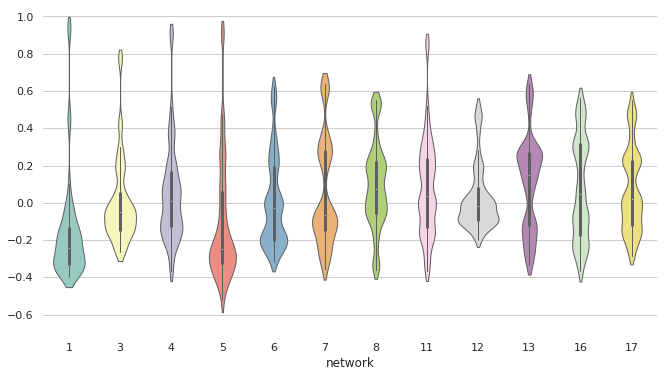

In [32]:



import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# Load the example dataset of brain network correlations
df = sns.load_dataset("brain_networks", header=[0, 1, 2], index_col=0)

# Pull out a specific subset of networks
used_networks = [1, 3, 4, 5, 6, 7, 8, 11, 12, 13, 16, 17]
used_columns = (df.columns.get_level_values("network")
                          .astype(int)
                          .isin(used_networks))
df = df.loc[:, used_columns]

# Compute the correlation matrix and average over networks
corr_df = df.corr().groupby(level="network").mean()
corr_df.index = corr_df.index.astype(int)
corr_df = corr_df.sort_index().T

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))

# Draw a violinplot with a narrower bandwidth than the default
sns.violinplot(data=corr_df, palette="Set3", bw=.2, cut=1, linewidth=1)

# Finalize the figure
ax.set(ylim=(-.7, 1.05))
sns.despine(left=True, bottom=True)


In [ ]:
avg_CC_randG = list(map(nk.globals.clustering, ER_graphs))
zscore_randG = zscore(ACC_nkG,np.mean(avg_CC_randG), np.std(avg_CC_randG))
print(zscore_randG)

In [ ]:
pvalues_ = pvalues(avg_CC_randG, 0.1 )
pvalues_

In [ ]:
avg_CC_randG